# ALMA ephemeris object imaging: continuum (mosaic gridder)

## Use 'TRACKFIELD' in phasecenter parameter 


## Description
The following demo describes continuum imaging of ALMA observation of Venus. For imaigng of the sources that move significantly during the observations, proper ephemeris data need to be used. For the current ALMA data, the epehemeris tables used to track the source during the observation generally included in the ASDM. The task, importasdm attaches the ephemeris table(s) in FIELD sub-table in the generated MS. Here we starts from such MS data and also uses a short cut option called 'TRACKFIELD' in tclean to use the attached ephemeris table(s).

## Data
The data is available at /home/casa/data/casatestdata.

## Installation
### Option 1

### Option 2

### Import libraries

In [5]:
from casatasks import getephemtable, tclean, exportfits, listobs, imstat, imhead
from casatools import measures, quanta, table, image
import os
from astropy.io import fits
from astropy.wcs import WCS
from matplotlib import pylab as pl
import numpy as np
import aplpy
me = measures()
qa = quanta()
tb = table()
ia = image()

#### Import utility functions defined in a separate notebook

In [7]:
# import helper functions defined in EphemerisObjectImagingDemoFunctions.ipynb, which need to be
# present in the directory running the jupyter notebook/jupyter-lab

# requires ipynb 
from ipynb.fs.defs.EphemerisObjectImagingDemoFunctions import *

## Imaging with epehemeris data attached to the MS

In order to track the ephemeris source during the observations, the proper ephemeris data is used. 
Ususally such ephemeris data table(s) are attached to the Measurement Set automatically during importadm when they are available. There may be multiple tables per MS but only single table is linked each field. The tables are used to calculate phases for gridding visibility. The ephemeis table is also used to stop the moving source. Setting phasecenter='TRACKFIELD' allows to use the same table for phase calculation and stopping of the moving source.

In [8]:
# Use the ALMA Venus data in casatestdata
datapath='/home/casa/data/casatestdata/measurementset/alma/'
# Use local data directory
#datapath='/Volumes/ssd1/casatestdata/measurementset/alma/'
#datapath='/Users/ttsutsum/SWDevel/ephemdemo/notebooks/'

In [9]:
# Copy the data to the local directory (not neccessary)
msfile='venus_ephem_test.ms'
if os.path.exists(msfile):
    shutil.rmtree(msfile)
os.system(f'cp -r {datapath}{msfile} {msfile}')

0

In [10]:
imgname='Venus-mosaic-mfs-trackfield'

In [11]:
delete_tcleanimages(imgname)

Run mosaic with usepointing = True to correctly shift the beam 

In [12]:
ret=tclean(vis=msfile, field='Venus', imagename=imgname, imsize=[480, 432], cell=['0.14arcsec'], 
           phasecenter='TRACKFIELD', specmode='mfs', gridder='mosaic', usepointing=True, niter=100)
ret['iterdone']

100

### Examination of the resultant image

Convert a CASA image to FITS image for displaying the image via aplpy

In [10]:
# Define functions to use in displaying the image
def displayImage(imgname, markers={}, title=''):
    ''' convert casa image to fits and display the fits image'''
    # export to a FITS image (overwrite if the output exists)
    from casatools import quanta
    _qa = quanta()
    fitsimagename = imgname+'fits'
    exportfits(imagename=imgname, fitsimage=fitsimagename, overwrite=True)
    fits.setval(fitsimagename, 'TIMESYS', value='utc')
    fig = pl.figure(figsize=(15,15))
    img = aplpy.FITSFigure(fitsimagename, subplot=[0.1,0.1,0.5,0.5])
    img.show_colorscale()
    if markers!={}:
       for ky, pos in markers.items(): 
          if 'ra' in pos and 'dec' in pos:
             print(f'ky={ky}')
             if 'ext' in ky: 
                 color = 'red'
             else:
                 color = 'yellow'
             img.show_markers(pos['ra'], pos['dec'], edgecolor=color, marker='o',s=10, alpha=0.5)
             marker_ra = _qa.time(_qa.quantity(pos['ra'],'deg'),prec=9)[0]
             marker_dec = _qa.angle(_qa.quantity(pos['dec'],'deg'),prec=9)[0]
             print(f'{ky} at: {marker_ra}, {marker_dec}')
    pl.title(title)
    fig.canvas.draw()
    print('image center:',printImageCenter(imgname))

#def displayImage(imgname, markers={}, title=''):
#    ''' convert casa image to fits and display the fits image'''
#    # export to a FITS image (overwrite if the output exists)
#    fitsimagename = imgname+'fits'
#    exportfits(imagename=imgname, fitsimage=fitsimagename, overwrite=True)
#    fits.setval(fitsimagename, 'TIMESYS', value='utc')
#    fig = pl.figure(figsize=(15,15))
#    img = aplpy.FITSFigure(fitsimagename, subplot=[0.1,0.1,0.5,0.5])
#    img.show_colorscale()
#    if markers!={}:
#       img.show_markers(markers['ra'], markers['dec'], edgecolor='red', marker='o',s=10, alpha=0.5)
#       marker_ra = qa.time(qa.quantity(markers['ra'],'deg'),prec=9)[0]
#       marker_dec = qa.angle(qa.quantity(markers['dec'],'deg'),prec=9)[0]
#       print(f'marker at: {marker_ra}, {marker_dec}')
#    pl.title(title)
#    fig.canvas.draw()
#    print('image center:',printImageCenter(imgname))

def printImageCenter(imgname):
    from casatools import image, quanta
    _ia = image()
    _qa = quanta()
    _ia.open(imgname)
    shape = _ia.shape()
    csys = _ia.coordsys()
    center = csys.toworld([shape[0]/2.,shape[1]/2.])
    _ia.done()
    return _qa.time(_qa.quantity(center['numeric'][0], 'rad'),prec=9)[0], _qa.angle(_qa.quantity(center['numeric'][1],'rad'),prec=9)[0]

# Returns direction of the ephemeris object at a given time (parallax collected)
def ephem_dir(ephemtab, refep, observatory):
    from casatools import measures
    _me = measures()
    _me.framecomet(ephemtab)
    _me.doframe(_me.observatory(observatory))
    _me.doframe(_me.epoch('utc',refep))
    return _me.measure(_me.measure(_me.direction('COMET'), 'AZELGEO'),'ICRS')
    

Get the direction of Venus at the first timestamp of the select data from the ephemeris table

In [15]:
# Find the path of the attached ephem. table for fieldid=0
ephemtab = get_attachedEphemtablepath(msfile,'Venus')
print(ephemtab)

venus_ephem_test.ms/FIELD/EPHEM0_Venus_58491.4.tab/


In [16]:
from casatasks import imhead
iminfo=imhead(imgname+'.image', mode='list')
iminfo['date-obs']

'2019/01/08/11:21:50.208000'

In [17]:

ineph_dir = ephem_dir(ephemtab, iminfo['date-obs'],'ALMA')
print(ineph_dir)
ineph_rad = qa.convert(ineph_dir['m0'],'deg')
ineph_decd = qa.convert(ineph_dir['m1'],'deg')
inephmarker = {'ineph':{'ra':ineph_rad['value'], 'dec':ineph_decd['value']}}

{'m0': {'unit': 'rad', 'value': -2.1053946095161686}, 'm1': {'unit': 'rad', 'value': -0.2960760011918846}, 'refer': 'ICRS', 'type': 'direction'}


INFO: Setting slices=[0, 0] [aplpy.core]


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


INFO: Auto-setting vmin to -3.693e+00 [aplpy.core]
INFO: Auto-setting vmax to  3.680e+00 [aplpy.core]
ky=ineph
ineph at: 15:57:28.746, -016.57.50.059
image center: ('15:57:28.746', '-016.57.50.059')


<Figure size 1500x1500 with 0 Axes>

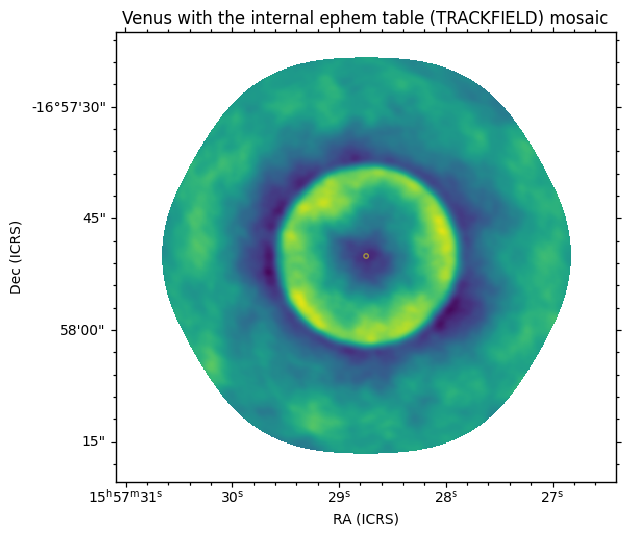

In [18]:
displayImage(imgname+'.image', markers=inephmarker, title='Venus with the internal ephem table (TRACKFIELD) mosaic')

Note: the marker in yellow is set to the direction based on the internal ephemeris table at the first time of the selected data and its coordintes agrees with the coordinates of the center of the image.

In [19]:
print("internal ephem dir = ",qa.time(ineph_dir['m0'],prec=9),qa.angle(ineph_dir['m1'],prec=9))
printImageCenter(imgname+'.image')

internal ephem dir =  ['15:57:28.746'] ['-016.57.50.059']


('15:57:28.746', '-016.57.50.059')

In [20]:
stats = imstat(imgname+'.image')
print(f"{stats['max']}@{stats['maxpos']}")

[3.33059001]@[177 172   0   0]
